# 1D parameter scan for cell signalling pathway 
nicole pagane
3/07/18

### import necessary modules

In [2]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as snt
from scipy.optimize import curve_fit
from numpy.linalg import svd
import os
import plotly.plotly as py
import plotly.graph_objs as go
from decimal import Decimal
from matplotlib.colors import LogNorm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [58]:
### SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
# K + K -> Kp + K  (k2)
# Kp+ K -> K + K   (k3)
# Kp+Kp -> Kpp+Kp  (k4)
# Kpp+Kp-> Kp+Kp   (k5)

fig = plt.figure(figsize=(10,8))

conc2 = 25
conc1 = 15


#equilibrium concentrations
S = np.mean([conc1, conc2])
Ktot = 50

Kp = np.linspace(0,Ktot,100)
Kpp = np.linspace(0,Ktot,100)

Km = 5
Ks = Km/Ktot 
theta = ((1+Ks)**2)/((1-2*Ks)**2) # k4k3/k2k5
print 'theta = ', theta

# kinetic rate constants
k1 = 1
k2 = 1
k3 = theta
k4 = theta
k5 = 1

#print 'assymetric factor =', (k4*k3)/(k2*k5)

#append to differential space
A = np.matrix(np.asarray([
                -k1, -k2, k3, 0, 0,
                k1, k2, -k3, -k4, k5, 
                0, 0, 0, k4, -k5 ]).reshape([3,5]))


theta =  1


/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

divide by zero encountered in log

/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning:

divide by zero encountered in log

/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning:

divide by zero encountered in log



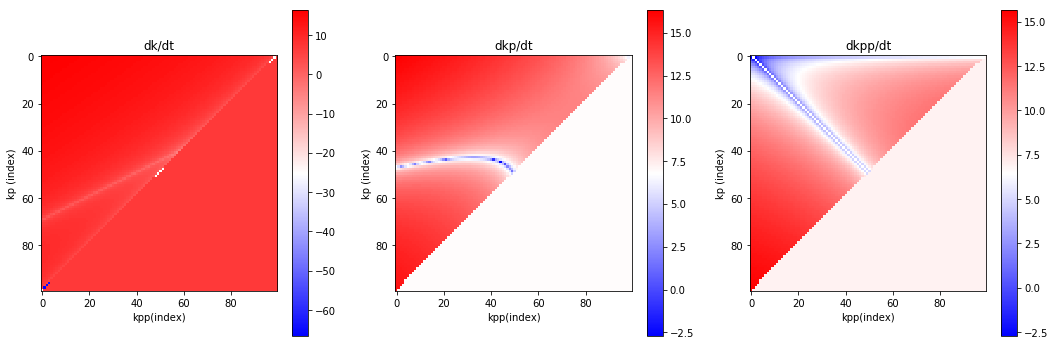

In [59]:
#find individual kinase differentials
dk = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
dkp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
dkpp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
for i in range(len(Kp)):
    for j in range(len(Kpp)):
        K = Ktot - Kp[i] - Kpp[j]
        if K >= 0:
            dk[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]**2,Kp[i]*Kpp[j]]).reshape([5,1])),2)[0]
            dkp[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]**2,Kp[i]*Kpp[j]]).reshape([5,1])),2)[1]
            dkpp[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]**2,Kp[i]*Kpp[j]]).reshape([5,1])),2)[2]

#plot
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,3,1)
plt.imshow(np.log(dk), cmap = 'bwr')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dk/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,2)
plt.imshow(np.log(dkp), cmap = 'bwr')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dkp/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,3)
plt.imshow(np.log(dkpp), cmap = 'bwr')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dkpp/dt')
plt.colorbar()

plt.show()

/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning:

divide by zero encountered in log



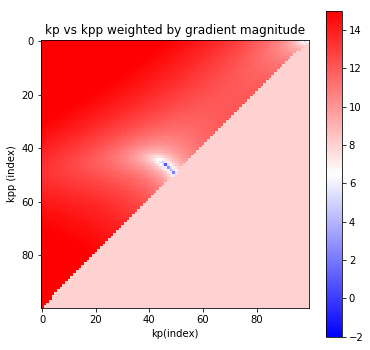

In [61]:
grad = np.log(dk + dkp + dkpp)

fig = plt.figure(figsize=(6,6))
plt.imshow(grad, cmap = 'bwr', vmax = 15, vmin = -2)
plt.xlabel('kp(index)')
plt.ylabel('kpp (index)')
plt.title('kp vs kpp weighted by gradient magnitude')
plt.colorbar()

plt.show()

In [62]:
#trace = go.Heatmap(z = np.log(grad.tolist()))
#data=[trace]
#py.iplot(data, filename='basic-heatmap')


In [63]:
#nullspace function courtesy of scipy
def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

### plot dkpp/dt for the numerical solutions of the kinetic laws to determine best fit parameters

In [64]:
tol = 4
mins = []
inds = []
for i in range(np.shape(grad)[0]):
    for j in range(np.shape(grad)[1]):
        if grad[i,j] < tol:
            mins.append(grad[i,j])
            inds.append([i,j])
                
mins = np.asarray(mins)
print len(inds), 'combination found under', tol, 'tolerance'
for i in range(len(inds)):
    print Ktot - Kp[inds[i][0]] - Kpp[inds[i][1]], Kp[inds[i][0]], Kpp[inds[i][1]]

5 combination found under 4 tolerance
0.0 0.0 50.0
3.53535353535 23.2323232323 23.2323232323
2.52525252525 23.7373737374 23.7373737374
1.51515151515 24.2424242424 24.2424242424
0.505050505051 24.7474747475 24.7474747475


In [65]:
def nullparam(S,K,kp, kpp):
    mat = np.matrix([
            [-k1*S*K, -k2*K**2, k3*K*kp, 0, 0], 
            [k1*S*K, k2*K**2, -k3*K*kp, -k4*kp**2, k5*kp*kpp], 
            [0, 0, 0, k4*kp**2, -k5*kp*kpp]
              ])
    nullmat = nullspace(mat)
    for i in range(3):
        if len(nullmat) == sum(nullmat[:,i] > 0):
            return nullmat[:,i]
    return np.zeros(len(nullmat))

T = 10

def rates(y, t, k1, k2, k3, k4, k5, S):
    return np.asarray([-k1*S*y[0] - k2*y[0]**2 + k3*y[1]*y[0],
                      k1*S*y[0] + k2*y[0]**2 - k3*y[1]*y[0] - k4*y[1]**2 + k5*y[2]*y[1],
                      k4*y[1]**2 -  k5*y[2]*y[1]])

odeTrials = {}
acc = []
newinds = []
ind = 0
n = 100
t = np.linspace(0,T,n)
for i in range(len(inds)):
    temp = nullparam(S, Ktot - Kp[inds[i][0]] - Kpp[inds[i][1]], Kp[inds[i][0]], Kpp[inds[i][1]])
    y0 = [float(Ktot)/2,3*float(Ktot)/4,float(Ktot)/4]
    if sum(temp > 0):
        newinds.append(inds[i])
        params = []
        for i in range(len(temp)):
            params.append(temp.tolist()[i][0])
        params.append(S)
        ode = snt.odeint(rates, y0,t, args = tuple(params))
        odeTrials[ind] = []
        odeTrials[ind] = ode
        acc.append(params)
        ind = ind+ 1

inds = newinds
print ind

3


In [66]:
#create traces
data = []
for i in odeTrials.keys():
    trace = go.Scatter(
    y = odeTrials[i][:,2][0:n-1],
    x = t,
    mode = 'lines',
    #name = ''.join([str('%.2E' % Decimal(params['k3'][i])), ", ", str('%.2E' % Decimal(params['k4'][i],2)), 
     #  ", ", str('%.2E' % Decimal(params['k5'][i],2))])
    )
    data.append(trace)

#py.iplot(data, filename='scatter-mode')

In [67]:
#create traces
data = []
for i in odeTrials.keys():
    dkpp = np.diff(odeTrials[i][:,2])/np.diff(t)
    trace = go.Scatter(
    x = odeTrials[i][:,2][0:n-1],
    y = dkpp,
    mode = 'lines',
    #name = ''.join([str('%.2E' % Decimal(params['k3'][i])), ", ", str('%.2E' % Decimal(params['k4'][i],2)), 
     #              ", ", str('%.2E' % Decimal(params['k5'][i],2))])
    )
    data.append(trace)

#py.iplot(data, filename='scatter-mode')

In [68]:
for i in range(len(acc)):
    for j in range(len(acc[i])):
        print acc[i][j]
    print 'theta =',(acc[i][3]*acc[i][2])/(acc[i][1]*acc[i][4])
    print

print 'minimum threshold', theta

0.530183130949
0.0544135395485
0.464698842661
0.5
0.5
20.0
theta = 8.54013259416

0.542859237849
0.0461806131183
0.450745159546
0.5
0.5
20.0
theta = 9.76048452174

0.548835065866
0.0370599036745
0.444304663509
0.5
0.5
20.0
theta = 11.9888240243

minimum threshold 1


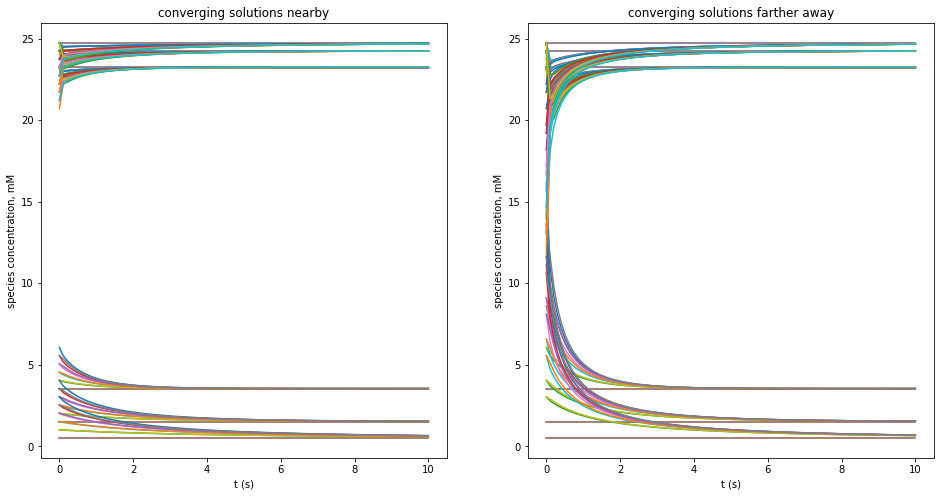

In [70]:
### see if kp, kpp combinations close to stable solution converge to stable solution

fig = plt.figure(figsize=(16,8))

pts = 10
var = 5
    
for iter in range(len(acc)):
    chosen = iter
    params = []
    for i in range(len(acc[chosen])):
        params.append(acc[chosen][i])
    ind = 0
    initsNear = {}
    initsFar = {}
    for i in range(-pts/2, pts/2):
        if i < 0:
            initsNear[ind] = [Ktot - Kp[inds[chosen][0]+i] - Kpp[inds[chosen][1]], Kp[inds[chosen][0]+i], Kpp[inds[chosen][1]]]
            initsFar[ind] = [Ktot - Kp[inds[chosen][0]+var*i] - Kpp[inds[chosen][1]], Kp[inds[chosen][0]+var*i], Kpp[inds[chosen][1]]]
        else:
            initsNear[ind] = [Ktot - Kp[inds[chosen][0]] - Kpp[inds[chosen][1]-i], Kp[inds[chosen][0]], Kpp[inds[chosen][1]-i]]
            initsFar[ind] = [Ktot - Kp[inds[chosen][0]] - Kpp[inds[chosen][1]-var*i], Kp[inds[chosen][0]], Kpp[inds[chosen][1]-var*i]]
        ind = ind + 1

    odeNear = {}
    odeFar = {}
    ind = 0
    n = 100
    t = np.linspace(0,T,n)
    for i in range(pts):
        y0 = initsNear[i]
        ode = snt.odeint(rates, y0,t, args = tuple(params))
        odeNear[ind] = []
        odeNear[ind] = ode
        y0 = initsFar[i]
        ode = snt.odeint(rates, y0,t, args = tuple(params))
        odeFar[ind] = []
        odeFar[ind] = ode
        ind = ind+ 1
        
    ax = fig.add_subplot(1,2,1)
    for i in odeNear.keys():
        for j in range(np.shape(odeNear[i])[1]):
            plt.plot(t, odeNear[i][:,j][0:n])
    ax.set_xlabel('t (s)')
    plt.title('converging solutions nearby')
    ax.set_ylabel('species concentration, mM')

    ax = fig.add_subplot(1,2,2)
    for i in odeFar.keys():
        for j in range(np.shape(odeFar[i])[1]):
            plt.plot(t, odeFar[i][:,j][0:n])
    ax.set_xlabel('t (s)')
    plt.title('converging solutions farther away')
    ax.set_ylabel('species concentration, mM')

plt.show()

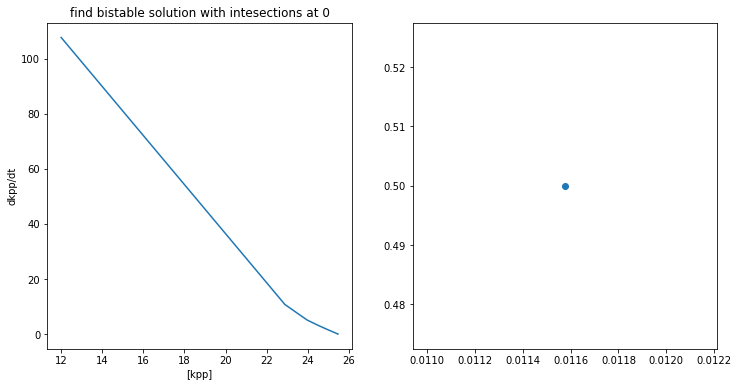

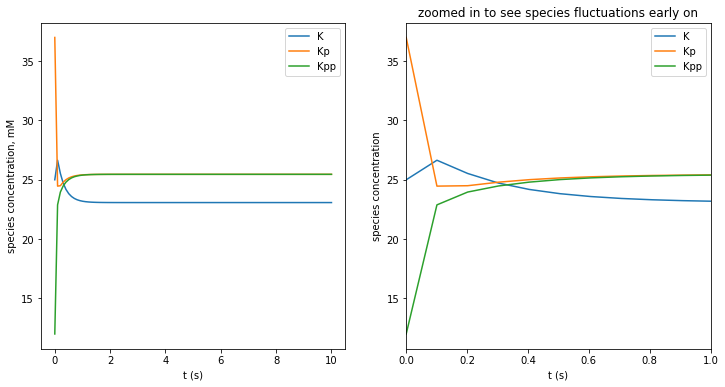

In [43]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
# K + K -> Kp + K  (k2)
# Kp+ K -> K + K   (k3)
# Kp+Kp -> Kpp+Kp  (k4)
# Kpp+Kp-> Kp+Kp   (k5)


#rate constants
k1 = params[0]
k2 = params[1]
k3 = params[2]
k4 = params[3]
k5 = params[4]

#initial concentrations
c1 = float(conc2 + conc1)/(2)
c2 = Ktot/2
c3 = 3*Ktot/4
c4 = Ktot/4
V =1
y0 = np.asarray([c2, c3, c4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5, S))

#find dkpp/dt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
dkpp = np.diff(ode[:,2])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('find bistable solution with intesections at 0')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')

#plot two parameters against each other to determine bistable solution
ax = fig.add_subplot(1,2,2)
ax.plot(k2, k5, 'o')


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])

#zoom in 
ax = fig.add_subplot(1,2,2)
t = np.linspace(0, T, n)
ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5,S))
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
ax.set_title('zoomed in to see species fluctuations early on')
ax.set_ylabel('species concentration')
ax.legend(['K', 'Kp', 'Kpp'])
ax.set_xlim([0,1])


plt.show()